# Home assignment 3 (17 pts) 

## Only filled ipynb file should be submitted in Stepik!

## Problem 1. Control by landing of spaceship (10 pts)

Practical implementation of the ideas from this problem see [here](https://www.youtube.com/watch?v=2t15vP1PyoA)

In this problem we assume that the dynamic of spaceship controls by the Newton's second law

$$
mx''(t) = f(t) - mge_3,
$$

where $e_3$ is a vector $(0, 0, 1)$, $m$ is a mass that is constant by our assumption (otherwise we will get much complicated dynamic), $f(t)$ is a force that we can control, $x''(t)$ is acceleration.
We also skip the atmosphere affects.
This is vector equation, so $x(t)$ and $f(t)$ and 3D vectors in every timestamp. 

#### Dynamic equation we can get after discretization of the above equation

For speed we get

$$
m\frac{v_{k+1} - v_k}{h} = f_k - mge_3, \quad v_{k+1} = v_k + \frac{h}{m} f_k - hge_3
$$

and similarly for coordinates

$$
x' = v \quad x_{k+1} = x_k + \frac{h}{2}(v_k + v_{k+1})
$$

We use here Runge-Kutta method of the order 2, more details see [here](http://web.mit.edu/10.001/Web/Course_Notes/Differential_Equations_Notes/node5.html).

The landing point has coordinates $(0, 0, 0)$ and for successful landing the final speed has to be zero. 
Also, during the landing it is important to prevent shift of the spaceshift in the vertical axis, so the $z$-coordinate can not be smaller than its projection on the plane $(x, y)$ in given factor

$$
x_3(t) \geq \alpha \| (x_1(t), x_2(t)) \|_2.
$$

Since force is created my engine that consumes fuel, we have some upper bound on the force

$$
\|f(t)\|_2 \leq F_{\max}.
$$

Also the amount of the consumed fuel can be computed by the following equation

$$
\gamma \int_0^T \|f(t)\|_2 dt,
$$

 where $\gamma$ is a fuel consumption coefficient, $T$ is a landing time. 
 
During time discretization we can assume that $f(t)$ is constant in every interval $[(k-1)h; kh]$ for $k=1,\ldots,K$. Thus, the total time for landing is $Kh$. 

**Task 1**
Find the position, speed and forse in evert timestamp such that the total amount of consumed fuel is minimal

1) (2 pts) State optimization problem formally. It means define the objective function, variables and constraints explicitly in mathematical way.

2) (3 pts) Solve it with CVXPy and visualize solution 

**Task 2**
Find the minimal time that is sufficient to land the spaceship. i.e. if the time discretization step $h$ is fixed, we need to find the minimal time to move spaceship from the initial point to the final point with final speed.
You can solve multiple auxilliary problem to solve this problem.

3) (5 pts) State optimization problem formally and simplify as much as possible

4) (4 pts) Solve it with CVXPy and visualize solution. Compare the resulted trajectory with the trajectory from the task 1. How much requirement of the minimal time increased the amount of consumed fuel?

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib inline
import cvxpy as cvx

# Time discretiztion step
h = 1.
# Gravity acceleration. It is just demo value to scale the solution time!
g = 0.1
# Mass
m = 10.
# Maximum norm of forse
Fmax = 10.
# Initial position
p0 = np.array([50, 50, 100])
# Initial velocity
v0 = np.array([-10, 0, -10])
# Factor of minimum slope
alpha = 0.5
# Fuel consumption factor
gamma = 1.
# Number of discretization steps, i.e. final time equals K*h
K = 35

# My solution is here:
# ***Problem 1. Task 1.1 - State optimization problem formally:***

We need solve this (convex) problem:

*Mininize*:
$$
\gamma \int_0^T \|f(t)\|_2 dt,
$$
which is equivalent (with $γ$=1, $h$=$Δt$=1 and $N$ - const) to  
$$ 
\sum_{k=1}^N \|f_k\|_2 
$$ 
*Subject to:*

Conditions # 1 - For speed $v$:
$$
\quad v_{k+1} = v_k + \frac{h}{m} f_k - hge_3   
$$ 

Conditions # 2 - For coordinates:
$$
\quad x_{k+1} = x_k + \frac{h}{2}(v_k + v_{k+1})
$$

Conditions # 3 - For $z$:
$$
x_3(t) \geq \alpha \| (x_1(t), x_2(t)) \|_2.
$$

Conditions # 4 - For force $f$:
$$
\|f(t)\|_2 \leq F_{\max}.
$$

Conditions # 5 - Start conditions:
$$
\quad p_{start}=p_{0}
\quad v_{start}=v_{0}
$$
Conditions # 6 - End conditions:
$$
\quad p_{end}=p_{N+1}=0
\quad v_{end}=v_{N+1}=0 
$$

With variables:
$$
\quad p_1,...,p_{N+1}(p_{end})
$$
$$
\quad v_1,...,v_{N+1}(v_{end})
$$ 
$$
\quad f_1,...,f_{N}
$$


**The convexity:**

1.Conditions # 1, 2, 5, 6 - affine

2.Conditions # 3, 4 - convex

3.Objective function is a convex

From 1., 2., 3. => Our problem is a **convex problem**.

# My solution:
# **Problem 1. Task 1.2 - Solve it with CVXPy\:**

In [ ]:
p1 = cvx.Variable((3, K+1))
v = cvx.Variable((3, K+1))
f = cvx.Variable ((3, K))

total_fuel = h*gamma*sum([cvx.norm(f[:,i]) for i in range(K)])

z = np.array([0,0,1])

constraints_for_speed = [v[:,i+1] == \
                         v[:,i] + (h/m)*f[:,i]-h*g*z for i in range(K)]
constraints_for_point = [p1[:,i+1] == \
                         p1[:,i] + h/2*(v[:,i]+v[:,i+1]) for i in range(K)]

constraints_for_z = [p1[2,i] >= alpha*cvx.norm(p1[0:2,i]) for i in range(K+1)]
constraints_for_f = [cvx.norm(f[:,i]) <= Fmax for i in range(K)]

constraints_for_start = [p1[:,K]==0, v[:,K]==0]
constraints_for_end = [p1[:,0]==p0, v[:,0]==v0]

all_constraints = constraints_for_speed + constraints_for_point \
              + constraints_for_z + constraints_for_f \
              + constraints_for_start + constraints_for_end              

prob = cvx.Problem(cvx.Minimize(total_fuel), constraints=all_constraints)
prob.solve()

print (f'The total minimal amount of consumed fuel is:  {total_fuel.value}')

Fuel = total_fuel.value

The total minimal amount of consumed fuel is:  192.99122538671148


# My solution:
# **Problem 1. Task 2.1 - State optimization problem formally:**

We need solve a series of convex feasibility problems and find minimal time to landing, until we find mininal K:

*Mininize*:
$$
K(time)->min
$$
$$
cvx.Minimize(0)
$$

*Subject to:*

Conditions # 1 - For speed $v$:
$$
\quad v_{k+1} = v_k + \frac{h}{m} f_k - hge_3   
$$ 

Conditions # 2 - For coordinates:
$$
\quad x_{k+1} = x_k + \frac{h}{2}(v_k + v_{k+1})
$$

Conditions # 3 - For $z$:
$$
x_3(t) \geq \alpha \| (x_1(t), x_2(t)) \|_2.
$$

Conditions # 4 - For force $f$:
$$
\|f(t)\|_2 \leq F_{\max}.
$$

Conditions # 5 - Start conditions:
$$
\quad p_{start}=p_{0}
\quad v_{start}=v_{0}
$$
Conditions # 6 - End conditions:
$$
\quad p_{end}=p_{N+1}=0
\quad v_{end}=v_{N+1}=0 
$$

With variables:
$$
\quad p_1,...,p_{N+1}(p_{end})
$$
$$
\quad v_1,...,v_{N+1}(v_{end})
$$ 
$$
\quad f_1,...,f_{N}
$$


**The convexity:**

1.Conditions # 1, 2, 5, 6 - affine

2.Conditions # 3, 4 - convex

3 Formally - our objective function is convex. Line f(K) = K -> min is affine (hence, convex), and if we see on cvx.Minimize(0), then point 0 also affine(and hence, convex). And technically - if the problem is feasible we fix K, otherwise, we increase K.

From 1., 2., 3. => We have series convex problem.

# My solution:
# **Problem 1. Task 2.2 - Solve it with CVXPy\:**

In [ ]:
K = 1

while True:
  p2 = cvx.Variable((3, K+1))
  v = cvx.Variable((3, K+1))
  f = cvx.Variable ((3, K))

  z = np.array([0,0,1])
  constraints_for_speed = [v[:,i+1] == \
                           v[:,i] + (h/m)*f[:,i]-h*g*z for i in range(K)]
  constraints_for_point = [p2[:,i+1] == \
                           p2[:,i] + h/2*(v[:,i]+v[:,i+1]) for i in range(K)]

  constraints_for_z = [p2[2,i] >= alpha*cvx.norm(p2[0:2,i]) for i in range(K+1)]
  constraints_for_f = [cvx.norm(f[:,i]) <= Fmax for i in range(K)]

  constraints_for_start = [p2[:,K]==0, v[:,K]==0]
  constraints_for_end = [p2[:,0]==p0, v[:,0]==v0]

  all_constraints = constraints_for_speed + constraints_for_point \
                + constraints_for_z + constraints_for_f \
                + constraints_for_start + constraints_for_end              

  problem = cvx.Problem(cvx.Minimize(0), constraints=all_constraints)
  problem.solve()

  if problem.status==cvx.OPTIMAL:
    break
  K += 1

print (f'The minimum time until landing: {K}')

Time = K

The minimum time until landing: 25


# My solution:
# **Problem 1. Task 1.2 and Task 2.2 - Visualize solutions\:**

The total minimal amount of consumed fuel is:  192.99122538671148
The minimum time until landing: 25


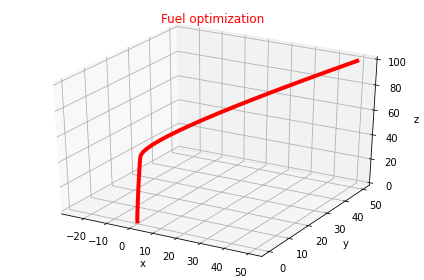

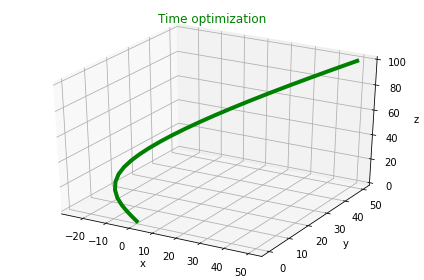

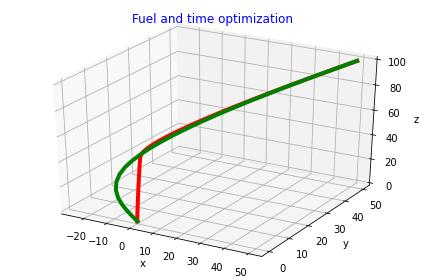

In [ ]:
print (f'The total minimal amount of consumed fuel is:  {Fuel}')
print (f'The minimum time until landing: {Time}')

# use the following code to plot your trajectories
# and the glide cone
# -------------------------------------------------------
fig = plt.figure()
ax = fig.gca(projection='3d')
plt.title("Fuel optimization", c="red")

X1 = np.linspace(-40, 55, num=30)
Y1 = np.linspace(0, 55, num=30)
X1, Y1 = np.meshgrid(X1, Y1)
Z1 = alpha*np.sqrt(X1**2+Y1**2)
# ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0)
ax.plot(xs=p1.value[0,:],ys=p1.value[1,:],zs=p1.value[2,:], c="red", \
        linewidth=4, markersize=22)
ax.set_xlabel('x'); ax.set_ylabel('y'); ax.set_zlabel('z')
plt.tight_layout()

fig = plt.figure()
ax = fig.gca(projection='3d')
plt.title("Time optimization", c="green")

X = np.linspace(-40, 55, num=30)
Y = np.linspace(0, 55, num=30)
X, Y = np.meshgrid(X, Y)
Z = alpha*np.sqrt(X**2+Y**2)
# ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0)
ax.plot(xs=p2.value[0,:],ys=p2.value[1,:],zs=p2.value[2,:], c="green", \
        linewidth=4, markersize=22) 
ax.set_xlabel('x'); ax.set_ylabel('y'); ax.set_zlabel('z')
plt.tight_layout()

fig = plt.figure()
ax = fig.gca(projection='3d')
plt.title("Fuel and time optimization", c="blue")

X = np.linspace(-40, 55, num=30)
Y = np.linspace(0, 55, num=30)
X, Y = np.meshgrid(X, Y)
Z = alpha*np.sqrt(X**2+Y**2)
# ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0)
ax.plot(xs=p1.value[0,:],ys=p1.value[1,:],zs=p1.value[2,:], c="red", \
        linewidth=4, markersize=22)
ax.plot(xs=p2.value[0,:],ys=p2.value[1,:],zs=p2.value[2,:], c="green", \
        linewidth=4, markersize=22) 
ax.set_xlabel('x'); ax.set_ylabel('y'); ax.set_zlabel('z')
plt.tight_layout()

## Problem 2. Nonnegative matrix factorization (7 pts) 

__1.__ Download the the code below a dataset with photos and plot any of the samples.

In [ ]:
import sklearn.datasets as skldata
import matplotlib.pyplot as plt
import sklearn.decomposition as skdec
%matplotlib inline
data = skldata.fetch_olivetti_faces()
import numpy as np

Shape of data = (400, 64, 64)


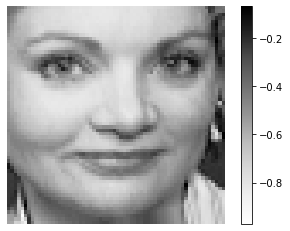

In [ ]:
print("Shape of data = {}".format(data["images"].shape))
index = 345
plt.imshow(-data["images"][index], cmap=plt.cm.Greys)
plt.colorbar()
_ = plt.axis("off")

__2.__ One of the classical approach to image and in general signal processing is [nonnegative matrix factorization](https://arxiv.org/pdf/1401.5226.pdf)). 
Idea of the method is to solve the following optimization problem

\begin{align*}
& \min_{W, H} \frac12 \|X - WH\|^2_F \\
\text{s.t. } & W \geq 0\\
& H \geq 0,
\end{align*}

where symbol $\geq$ denotes elementwise comparison. 
Also matrices $W$ and $H$ are lowrank, i.e. $W \in \mathbb{R}^{m \times k}$ and $H \in \mathbb{R}^{k \times n}$, where $k$ is a hyper-parameter that has to be tuned.
The larger $k$, the more accurate approximation, but more time is needed to solve the problem.
The matrix $X \in \mathbb{R}^{m \times n}$, where $m$ is a number of photos in our dataset, and $n$ is a umber of pixels in every picture, i.e. every row of the matrix $X$ is a vectorized image.

**Tasks**

1) (1 pts) is the above problem convex and why?

2) (1 pts) how can you interpret factors $W$ and $H$ and why its nonnegativity is important?

# My solution:
# **Problem 2. Task 2.1. Is the above problem convex and why?**

Our problem is not convex.

Let consider the $1d$ case with $m=n=1$, then problem is:

$$
min (x-wh)^2 = min (x^2 -2xwh+ w^2h^2)
$$

and we have objective function

$$
f(w, h) = x^2 -2xwh+ w^2h^2
$$
with gradient
$$
∇f_w(w,h)=2wh^2-2xh
$$
$$
∇f_h(w,h)=2w^2h-2xw
$$
and Hessian
$$
∇^2f_{ww} = 2h^2
$$
$$
∇^2f_{wh} = ∇^2f_{hw} = 4wh-2x
$$
$$
∇^2f_{hh} = 2w^2
$$

First principle leading minor is positive or equal zero.
$$
2h^2 \geq 0
$$
Second principle leading minor is not positive:
$$
 −12w^2h^2 −4x^2 +64hwx \le 0
$$
⇒ According to Silvester's criterion the Hessian 
is not positive semi-definite. 

This means that **our problem is not convex**.

# My solution:
# **Problen 2 Task 2.2 How can you interpret factors  W  and  H  and why its nonnegativity is important?**

The NMF basis is that its images are localized features that correspond better with intuitive notions of the parts of faces.
The NMF construct approximate factorizations of the form 
$$
 X ≈ WH
$$

$$
X_{nm}≈ (WH)_{nm} = \sum_{i=1}^k W_{ni}H_{im}
$$
The $r$ columns of $W$ are called basis images.

Each column of $H$ is called an encoding and is in one-to-one correspondence with a face in $X$. 

An encoding consists of the coefficients by which a face is
represented with a linear combination of basis images. The dimensions
of the matrix factors $W$ and $H$ are $n$ x $r$ and $r$ x $m$, respectively.
The rank $r$ of the factorization is generally chosen so that
($n$+$m$)*$r$ < $n$*$m$, and the product $WH$ can be regarded as a compressed
form of the data in $X$.

NMF does not allow negative entries in the matrix factors $W$ and $H$. These non-negativity constraints permit the combination of multiple basis images to represent a face. But only additive combinations are allowed, because the non-zero elements of $W$ and $H$ are all positive. No subtractions can occur. For these reasons, the non-negativity constraints are compatible with the intuitive notion of combining parts to form a whole, which is how NMF learns a parts-based representation.

The above is equally true in other types of tasks (not just for images).

**I used when answering this question:**  Learning the parts of objects by non-negative matrix factorization, Daniel D. Lee & H. Sebastian Seung, NATURE |VOL 401 | 21 OCTOBER 1999 |www.nature.com

__3.__ This problem can be approximately solved with CVXPy if the alternating optimization is used. The idea of this method is in even iterations solve the problem w.r.t $W$ while the matrix $H$ is fixed and in the odd iterations use optimal value of $W$ from the previous iteration as a fixed matrix and solve the problem w.r.t. $H$. And keep such alternating until convergence w.r.t. the changing the objective function.
Before run this method you need to initialize matrices $W$ and $H$ with some non-negative elements, probably random. The quality of the solution and running time of the method crucially depend on the initialization. So, you can test different approaches and report result of your investigation additionally.

**Tasks**

1) (2 pts) implement with CVXPy the alternating optimization method for this problem and solve it for some reasonable fixed $k$

2) (1 pts) plot the convergence line (objective function value vs. iteration idx) and confirm that the method converegs or the changing in objective function with iterating is very small

3) (1 pts) since the dimension of matrix $H$ is $k \times n$, then every row of $H$ can be transformed to photo in the inverse manner like they were collected in rows of matrix $X$. Plot 10-50 pictures extracted from rows of matrix $H$. What do you observe and how your observation relates to your answer the question 2) in the previous block of tasks? Use ```plt.colorbar()``` and colour scheme ```plt.cm.Greys``` for more constrast displaying the pixels

4) (1 pts) Plot matrix $W$ with functions ```plt.imshow``` or ```plt.spy``` from the ```matplotlib``` library. How much sparse is it?

# My solution:
# **Problem 2 Task 3.1 implement with CVXPy**
the alternating optimization method for this problem and solve it for some reasonable fixed $k$ 

**To speed up the calculation:**

$k$ = 9

Number of iterations MAX_ITERS = 20

And I use only a part of the data

but this is quite enough to draw conclusions.

In [6]:
!pip install scs==2.1.4

In [7]:
import sklearn.datasets as skldata
import matplotlib.pyplot as plt
import sklearn.decomposition as skdec
%matplotlib inline
import numpy as np
import cvxpy as cvx

data = skldata.fetch_olivetti_faces()
print(data['data'].shape)

(400, 4096)


In [8]:
# Alternating minimization.
_, n = data['data'].shape

k = 9
m = 20

np.random.seed(0)
W = np.random.rand(m, k)

MAX_ITERS = 20
residual = np.zeros(MAX_ITERS)
for iter_num in range(1, 1 + MAX_ITERS):
  X = data['data'][70:90]  
  if iter_num % 2 == 1:
    H = cvx.Variable(shape=(k, n))
    constraint = [H >= 0]  
  else:
    W = cvx.Variable(shape=(m, k))
    constraint = [W >= 0]
  
  obj = cvx.Minimize(0.5 * cvx.norm(X - (W @ H), 'fro') ** 2)
  prob = cvx.Problem(obj, constraint)
  prob.solve(cvx.SCS)

  if prob.status != cvx.OPTIMAL:
    print(f'\n Iteration {iter_num} result not optimal')        
  else:
    print(f'Iteration {iter_num}, residual norm {prob.value}')
    residual[iter_num - 1] = prob.value
        
  if iter_num % 2 == 1:
    H = H.value
  else:
    W = W.value
        
print(f"Objective function in total - {residual}")

Iteration 1, residual norm 947.0124491555234
Iteration 2, residual norm 214.20550354360884
Iteration 3, residual norm 122.00192406980852
Iteration 4, residual norm 105.18979889380051
Iteration 5, residual norm 96.87037744313191
Iteration 6, residual norm 91.2554770400563
Iteration 7, residual norm 87.19971481387739
Iteration 8, residual norm 84.12485106585991
Iteration 9, residual norm 81.6972153429369
Iteration 10, residual norm 79.70115155734362
Iteration 11, residual norm 78.07449762890876
Iteration 12, residual norm 76.67169294370817
Iteration 13, residual norm 75.49779755301513
Iteration 14, residual norm 74.46005048879891
Iteration 15, residual norm 73.56715782732347
Iteration 16, residual norm 72.75265984696202
Iteration 17, residual norm 72.065755729775
Iteration 18, residual norm 71.46644866997954
Iteration 19, residual norm 70.94196043833864
Iteration 20, residual norm 70.4601285424681
Objective function in total - [947.01244916 214.20550354 122.00192407 105.18979889  96.8703

# My solution:
# **Problem 2 Task 3.2 plot the convergence line**
(objective function value vs. iteration idx) and confirm that the method converegs or the changing in objective function with iterating is very small

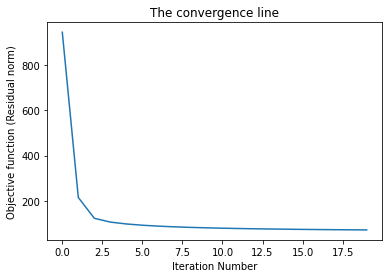

In [9]:
plt.plot(residual)
plt.title('The convergence line')
plt.xlabel('Iteration Number')
plt.ylabel('Objective function (Residual norm)')
plt.show()

# My solution:
# **Problem 2 Task 3.3**
Since the dimension of matrix H is k×n, then every row of H can be transformed to photo in the inverse manner like they were collected in rows of matrix X. Plot pictures extracted from rows of matrix H. What do you observe and how your observation relates to your answer the question 2) in the previous block of tasks? Use plt.colorbar() and colour scheme plt.cm.Greys for more constrast displaying the pixels.

**As we expected in Task 2.2, the matrix H contains compressed images form matrix X:**

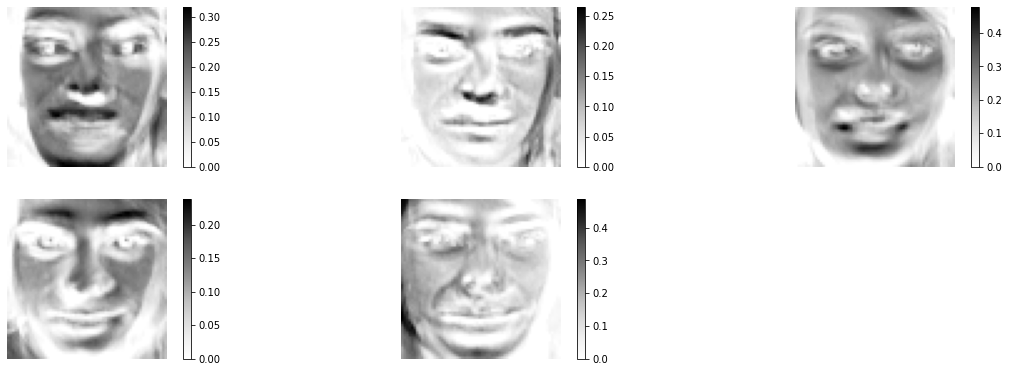

In [10]:
fig = plt.figure(figsize=(20, 10))
for i in range(1, 6):
    fig.add_subplot(3, 3, i)
    plt.imshow(H.T[:,i - 1].reshape(64,64), cmap=plt.cm.Greys)
    plt.colorbar()
    _ = plt.axis("off")
plt.show()

# My solution:
# **Problem 2 Task 3.4 Plot matrix W**
 with functions plt.imshow or plt.spy from the matplotlib library. How much sparse is it?

The sparsity of a matrix can be quantified with a score, which is the number of zero values in the matrix divided by the total number of elements in the matrix.

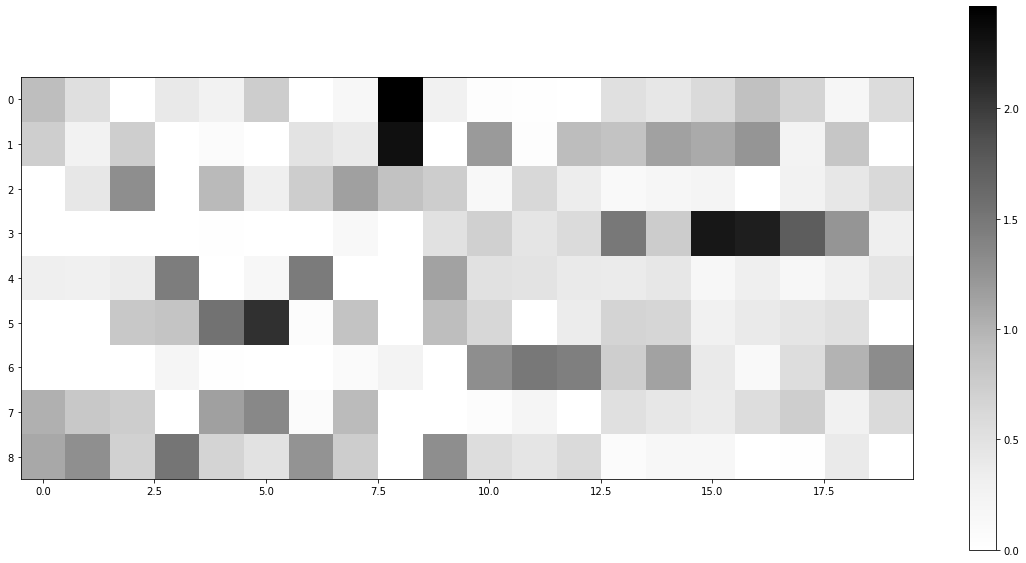

The sparcity matrix W is 0.35, with epsilon = 0.2 and mean for W = 0.5275707257876249


In [13]:
plt.figure(figsize=(20, 10))
plt.imshow(W.T, cmap=plt.cm.Greys)
plt.colorbar()
plt.show()

zero_elements_counter = 0
eps = 0.2
row, column = W.shape
for i in range(row):
  for j in range(column):
    if W[i][j] < eps:
      zero_elements_counter += 1

sparsity = zero_elements_counter / W.size
print(f'The sparcity matrix W is {sparsity}, with epsilon = {eps} and mean for W = {W.mean()}')